This example shows how to set up a fermionic PEPS with U(1) symmetry at half-filling using `symmray` and `quimb`, then optimize using imaginary time simple update, then evaluate the energy using boundary contraction.

In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn

import symmray as sr

In [2]:
symmetry = "U1"

Lx = 4
Ly = 4
D = 6


def site_charge(site):
    # put one fermion per site
    return 1

    # put two fermions on odd sites -> half filling
    # return 2 * ((site[0] + site[1]) % 2)


peps = sr.PEPS_fermionic_rand(
    symmetry=symmetry,
    Lx=Lx,
    Ly=Ly,
    bond_dim=D,
    seed=42,
    phys_dim=4,
    site_charge=site_charge,
)

print(peps.arrays[0])

U1FermionicArray(ndim=3, charge=1, indices=[
    (6 = 1+1+1+1+1+1 : +[-2,-1,0,1,2,3])
    (6 = 1+1+1+1+1+1 : +[-2,-1,0,1,2,3])
    (4 = 1+2+1 : +[0,1,2])
], num_blocks=15, backend=numpy, dtype=float64)


In [3]:
# impose neel order (NOTE: only for U1 and 1 fermion per site!)
for i, j in peps.gen_site_coos():
    # get the tensor data at site (i, j)
    t = peps[i, j]
    # get the sector: 0s on bonds and 1 on physical leg
    key = (0,) * (t.ndim - 1) + (1,)
    # get the index within the block to assign
    selector = (0,) * (t.ndim - 1) + (0 if (i + j) % 2 == 0 else 1,)
    # assign a much larger weight than the current random ones
    t.data.blocks[key][selector] = 100

In [4]:
# verify the spin structure using a basic cluster expectation
Ospin = sr.fermi_spin_operator_local_array(symmetry)

peps.compute_local_expectation_cluster(
    {(site,): Ospin for site in peps.gen_site_coos()},
    return_all=True,
)

{((0, 0),): array(-0.49940142),
 ((0, 1),): array(0.49691275),
 ((0, 2),): array(-0.49482876),
 ((0, 3),): array(0.49724477),
 ((1, 0),): array(0.49515941),
 ((1, 1),): array(-0.47291074),
 ((1, 2),): array(0.47007018),
 ((1, 3),): array(-0.49493919),
 ((2, 0),): array(-0.49295516),
 ((2, 1),): array(0.47213635),
 ((2, 2),): array(-0.47206349),
 ((2, 3),): array(0.49375622),
 ((3, 0),): array(0.49917827),
 ((3, 1),): array(-0.49487848),
 ((3, 2),): array(0.49572495),
 ((3, 3),): array(-0.49923981)}

In [5]:
terms = sr.ham_fermi_hubbard_from_edges(
    symmetry=symmetry,
    edges=tuple(peps.gen_bond_coos()),
    t=1.0,
    U=8.0,
)
ham = qtn.LocalHam2D(Lx, Ly, terms)

print(next(iter(terms.values())))

U1FermionicArray(ndim=4, charge=0, indices=[
    (4 = 1+2+1 : +[0,1,2])
    (4 = 1+2+1 : +[0,1,2])
    (4 = 1+2+1 : -[0,1,2])
    (4 = 1+2+1 : -[0,1,2])
], num_blocks=19, backend=numpy, dtype=float64)


In [6]:
su = qtn.SimpleUpdateGen(
    peps,
    ham,
    # setting a cutoff is important to turn on dynamic charge sectors
    cutoff=1e-12,
    second_order_reflect=True,
    # SimpleUpdateGen computes cluster energies by default
    # which might not be accurate
    compute_energy_every=10,
    compute_energy_opts=dict(max_distance=1),
    compute_energy_per_site=True,
    # use a fixed trotterization order
    ordering="sort",
    # if the gauge difference drops below this, we consider the PEPS converged
    tol=1e-9,
)

In [7]:
# run the evolution, these are reasonable defaults
tau = 0.5 * D ** (-3 / 2)
steps = round(50 / tau)

su.evolve(steps, tau=tau)

n=590, D=6, tau=0.034, max|dS|=9.85e-10, energy≈-0.397602:  40%|####      | 590/1470 [03:28<05:11,  2.83it/s]


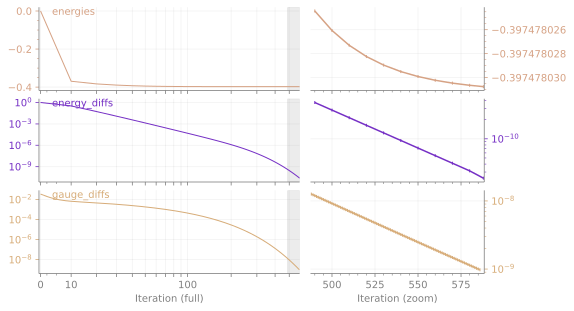

In [8]:
su.plot();

In [8]:
gs = su.get_state()

Check energy properly with boundary contraction and increasing $\chi$.

In [9]:
full_energies = {}

for chi in [16, 24, 32, 48, 64]:
    en = (
        gs.compute_local_expectation(
            ham.terms,
            normalized=True,
            max_bond=chi,
        )
        / gs.nsites
    )
    print(f"chi={chi}: E/N = {en}")
    full_energies[chi] = en

chi=16: E/N = -0.4155463373110228
chi=24: E/N = -0.4154680366479005
chi=32: E/N = -0.4154185088809899
chi=48: E/N = -0.4153858884378149
chi=64: E/N = -0.4153842381011851


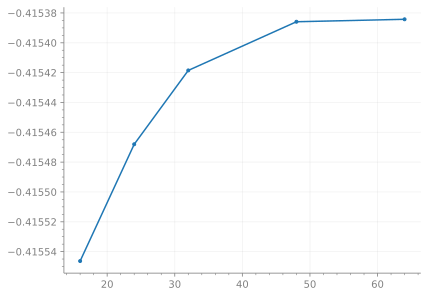

In [10]:
qu.plot(full_energies.keys(), full_energies.values(), marker=".");